# PPMI

In [4]:
library(dplyr)
library(data.table)
# Inverse normal transoformation
invNT=function(x){ 
  qnorm((rank(x,na.last="keep")-0.5)/sum(!is.na(x))) 
}

Warning message in eval_bare(f[[3]], env):
"NAs introduced by coercion"

DATA summary

      ID                 ASYN             CASE           FEMALE      
 Length:3235        Min.   : 235.8   Min.   : 0.00   Min.   :0.0000  
 Class :character   1st Qu.:1060.9   1st Qu.: 1.00   1st Qu.:0.0000  
 Mode  :character   Median :1422.5   Median : 1.00   Median :0.0000  
                    Mean   :1540.6   Mean   :20.96   Mean   :0.3713  
                    3rd Qu.:1844.8   3rd Qu.: 1.00   3rd Qu.:1.0000  
                    Max.   :8405.7   Max.   :99.00   Max.   :1.0000  
                                                                     
   YEARSEDUC     FAMILY_HISTORY      logASYN         invnASYN      
 Min.   : 0.00   Min.   :0.0000   Min.   :5.463   Min.   :-3.6075  
 1st Qu.:14.00   1st Qu.:0.0000   1st Qu.:6.967   1st Qu.:-0.6742  
 Median :16.00   Median :0.0000   Median :7.260   Median : 0.0000  
 Mean   :15.79   Mean   :0.1374   Mean   :7.250   Mean   : 0.0000  
 3rd Qu.:18.00   3rd Qu.:0.0000   3rd Qu.:7.520   3rd Qu.: 0.6742  
 Max.   :30.00   Max.   :1.0000 

HEMOGLOBIN summary (excluding obs with comments such as '>20', 'below', and 'above')

   HEMOGLOBIN     
 Min.   :  20.00  
 1st Qu.:  44.98  
 Median :  96.80  
 Mean   : 191.39  
 3rd Qu.: 234.70  
 Max.   :1227.30  

NOTE:
 In the following plots, the points at -500 were originally input as '>20'
 those at 1999 is originally input as 'avove'
 and those input as 'below' were replaced by the value of 10
 Planning to exclude obs with 'above' and '>20' from the analysis set.

These plots indicates CSF-hemoglobin doesn't seem to affect much in this cohort

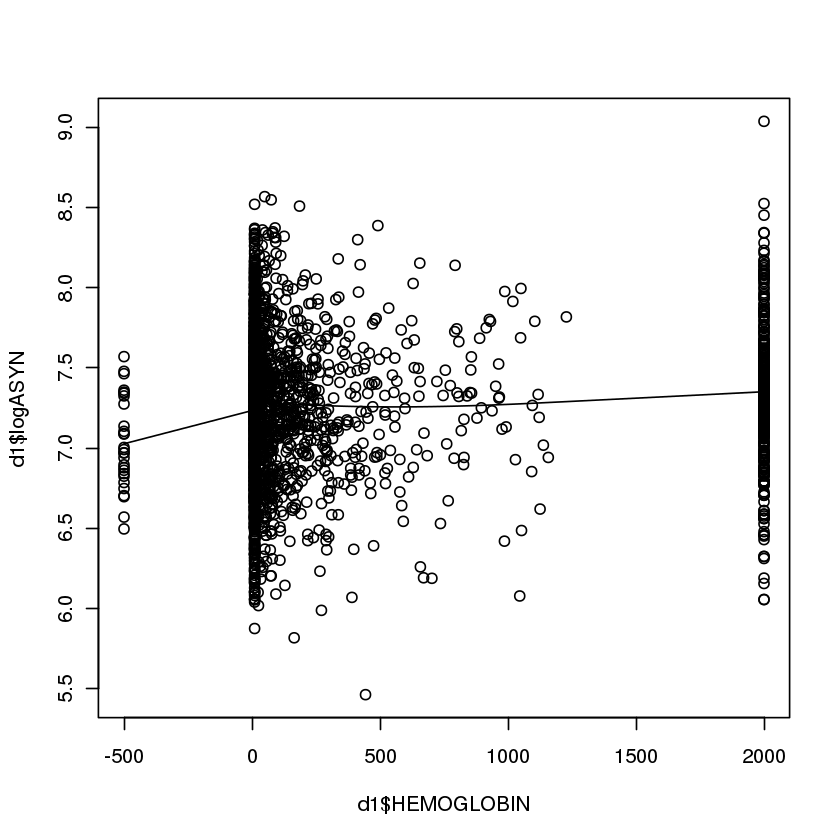

In [24]:
t1 = fread("data/02_LatestDiagDemog.csv", header=T) %>% 
  mutate(CASE = case_when(
    grepl("PD_YsImg_PPMI", DIAG) ~ 1, 
    grepl("CTR_YsImg_PPMI", DIAG) ~ 0,
    TRUE~ 99)) %>%
  select(ID, CASE, FEMALE, BIRTHDT, YEARSEDUC, FAMILY_HISTORY)

t2 = fread("t/asyn_hemo.txt", header=F, na.strings="N/A") %>% 
  mutate(V1 = as.character(V1)) %>% #  V1(ID) regarded as int
  filter(!is.na(V2) & !is.na(V3)) # delete "N/A" value observation in ANSN and HEMO
names(t2)=c("ID", "EVENT_ID","ASYN", "HEMO", "DATE")

d1 = left_join(t2, t1, by = "ID") %>% 
  mutate(logASYN=log(ASYN),
         invnASYN=invNT(ASYN)) %>% 
  mutate(HEMOGLOBIN = case_when(
    HEMO==">20"~ -500, # for elimination
    HEMO=="below"~ 10,
    HEMO=="above"~ 1999, # for elimination
    TRUE~ as.numeric(HEMO)),
    AGE = (as.numeric(as.Date(DATE)) - BIRTHDT)/365.25) %>% 
  select(-one_of("DATE", "BIRTHDT", "EVENT_ID", "HEMO")) %>% 
  arrange(HEMOGLOBIN)

cat("DATA summary")
summary(d1)

cat("HEMOGLOBIN summary (excluding obs with comments such as '>20', 'below', and 'above')")
d1 %>% filter(HEMOGLOBIN>10 & HEMOGLOBIN<1999) %>% select(HEMOGLOBIN) %>% summary     

cat("NOTE:
 In the following plots, the points at -500 were originally input as '>20'
 those at 1999 is originally input as 'avove'
 and those input as 'below' were replaced by the value of 10
 Planning to exclude obs with 'above' and '>20' from the analysis set.\n
These plots indicates CSF-hemoglobin doesn't seem to affect much in this cohort")
plot(d1$HEMOGLOBIN, d1$logASYN)
plx = predict(loess(d1$logASYN~d1$HEMOGLOBIN), se=T)
lines(d1$HEMOGLOBIN, plx$fit)


In [70]:
d2 = d1 %>% filter(HEMOGLOBIN>0 & HEMOGLOBIN<1500)
cat("CASE/HC/Others")
d2 %>% with(table(CASE), useNA="always")

cat("The following is a full model. As expected, HEMOGLOBIN level doesn't affect the outcome but 
sex and the disease status (CASE/HC/Other) are strong predictors. 
PCs will be added later and final model will be decided later")
lm(invnASYN~HEMOGLOBIN+FEMALE+YEARSEDUC+as.factor(CASE)+AGE+FAMILY_HISTORY, data=d2) %>% summary

d3 = d2 %>% # filter(CASE!=99) # comment-off if needed to analyze only CASE/CONTROL 
  mutate(IID = paste(ID, ID, sep="_"),
         DATASET="PPMI",
         rawASYN=ASYN) %>%
  select("DATASET", "IID","rawASYN", "logASYN", "invnASYN", "CASE", "FEMALE","YEARSEDUC", "HEMOGLOBIN", "AGE") %>% 
  arrange(IID)
write.table(d3, "t/phenoPPMI.txt", row.names = F, quote = F, sep = "\t")

CASE/HC/Others

CASE
   0    1   99 
 705 1580  608 

The following is a full model. As expected, HEMOGLOBIN level doesn't affect the outcome but 
sex and the disease status (CASE/HC/Other) are strong predictors. 
PCs will be added later and final model will be decided later


Call:
lm(formula = invnASYN ~ HEMOGLOBIN + FEMALE + YEARSEDUC + as.factor(CASE) + 
    AGE + FAMILY_HISTORY, data = d2)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5684 -0.6361  0.0150  0.6434  3.3776 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -6.180e-01  1.510e-01  -4.092 4.40e-05 ***
HEMOGLOBIN         8.034e-08  1.128e-04   0.001   0.9994    
FEMALE             2.175e-01  3.703e-02   5.874 4.75e-09 ***
YEARSEDUC         -1.355e-02  5.616e-03  -2.413   0.0159 *  
as.factor(CASE)1  -4.575e-01  4.410e-02 -10.374  < 2e-16 ***
as.factor(CASE)99 -2.997e-01  5.633e-02  -5.320 1.12e-07 ***
AGE                1.645e-02  1.822e-03   9.028  < 2e-16 ***
FAMILY_HISTORY     6.751e-02  5.412e-02   1.247   0.2124    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9567 on 2881 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.07097,	Adjusted R-squared

[1] "PPMI finish"


# ADNI

In [38]:
df=fread("../ADNI/180831/PTDEMOG.csv")
df1 = df %>% mutate(
  DATE = as.Date(USERDATE) %>% as.numeric, # 0 == "1970-1-1" 
  DOB = paste(PTDOBYY,PTDOBMM,"01", sep="-") %>% as.Date %>% as.numeric,
  YEARSEDUC=PTEDUCAT,
  FEMALE=I(PTGENDER==2)*1) %>% 
  select(Phase, ID, RID, SITEID, VISCODE, FEMALE, DATE, DOB, YEARSEDUC)
cat("Summary of DEMOGRAPHIC DATA. Longitudinally recoreded. DATE and DOB are counterd from 1970-01-01")
df1 %>% summary
#  df1 %>% filter(DOB>0) # Too young. Exclude these people
df2 = df1 %>% filter(DOB<0)
#  df2 %>% filter(YEARSEDUC<0) # some has '-1' . should be missing indicator/second observation indicator. Exclude
df3 = df2 %>% filter(YEARSEDUC>0)
cat("After exclude DOB>0 and YEARSEDUC<0, No NA observations")
df3 %>% summary
# The below line shows the inconsistent results across longitudinal observations. These should be individually checked. 
#  df3 %>% group_by(RID) %>% mutate_at(vars(names(df3)[c(6,8,9)]), funs( (. - first(.))^2)) %>% data.frame %>% mutate( INDICATOR = rowSums(.[,c(6,8,9)], na.rm=T)) %>%  filter(INDICATOR>0)
# Taking the value at the first observation seems OK.
df4 = df3 %>% arrange(DATE) %>% distinct(RID, .keep_all = T)
DEMO = df4 %>% select(RID, FEMALE, DOB, YEARSEDUC)

Summary of DEMOGRAPHIC DATA. Longitudinally recoreded. DATE and DOB are counterd from 1970-01-01

    Phase                 ID             RID             SITEID      
 Length:4294        Min.   :   12   Min.   :   1.0   Min.   :  1.00  
 Class :character   1st Qu.:  748   1st Qu.: 753.2   1st Qu.: 15.00  
 Mode  :character   Median : 1515   Median :2107.5   Median : 33.00  
                    Mean   : 5554   Mean   :2729.6   Mean   : 39.80  
                    3rd Qu.: 2596   3rd Qu.:4744.8   3rd Qu.: 50.75  
                    Max.   :60343   Max.   :6577.0   Max.   :127.00  
                                                                     
   VISCODE              FEMALE            DATE            DOB        
 Length:4294        Min.   :0.0000   Min.   :13012   Min.   :-19755  
 Class :character   1st Qu.:0.0000   1st Qu.:13473   1st Qu.:-14520  
 Mode  :character   Median :0.0000   Median :15146   Median :-12328  
                    Mean   :0.4604   Mean   :14958   Mean   :-11941  
                    3rd Qu.:1.0000   3rd Qu.:15538   3rd Qu.: -9437  
                    

After exclude DOB>0 and YEARSEDUC<0, No NA observations

    Phase                 ID               RID             SITEID      
 Length:4104        Min.   :   12.0   Min.   :   1.0   Min.   :  1.00  
 Class :character   1st Qu.:  737.5   1st Qu.: 780.8   1st Qu.: 15.00  
 Mode  :character   Median : 1511.0   Median :2158.5   Median : 33.00  
                    Mean   : 5648.6   Mean   :2790.4   Mean   : 39.81  
                    3rd Qu.: 2552.0   3rd Qu.:4780.5   3rd Qu.: 51.00  
                    Max.   :60343.0   Max.   :6577.0   Max.   :127.00  
   VISCODE              FEMALE            DATE            DOB        
 Length:4104        Min.   :0.0000   Min.   :13012   Min.   :-19755  
 Class :character   1st Qu.:0.0000   1st Qu.:13461   1st Qu.:-14520  
 Mode  :character   Median :0.0000   Median :15160   Median :-12328  
                    Mean   :0.4671   Mean   :14955   Mean   :-11974  
                    3rd Qu.:1.0000   3rd Qu.:15539   3rd Qu.: -9437  
                    Max.   :1.0000   Max.   :17773   Max.   : -2498  
   YEA

CSF-HEMOGLOBIN is dominating the log ASYN

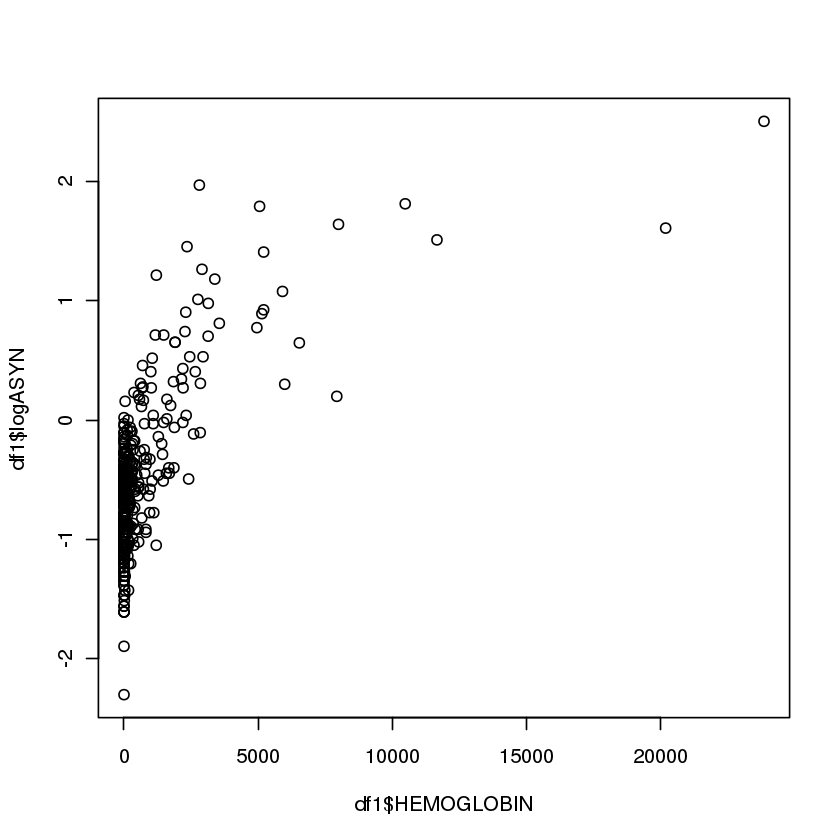

In [42]:
# Alpha Synuc
df=fread("../ADNI/180831/CSFALPHASYN_03_21_14.csv")
df1 = df %>% 
  mutate(DATE=as.Date(EXAMDATE) %>% as.numeric,
         logASYN=log(ALPHA_SYN),
         invnASYN=invNT(ALPHA_SYN),
         rawASYN=ALPHA_SYN)

cat("CSF-HEMOGLOBIN is dominating the log ASYN")
plot(df1$HEMOGLOBIN, df1$logASYN)

HEMOGLOBIN<1200


FALSE  TRUE  <NA> 
   56   333     0 

exclude obs with CSF-HEMOGLOBIN < 1200. But it still seeems to have a strong effect on ALPHA_SYN (below)
looking at variance, filter out obs with large HEMOGLOBIN values.
For the consistency, set the cut-off value at 1200 (PPMI max was 1227)


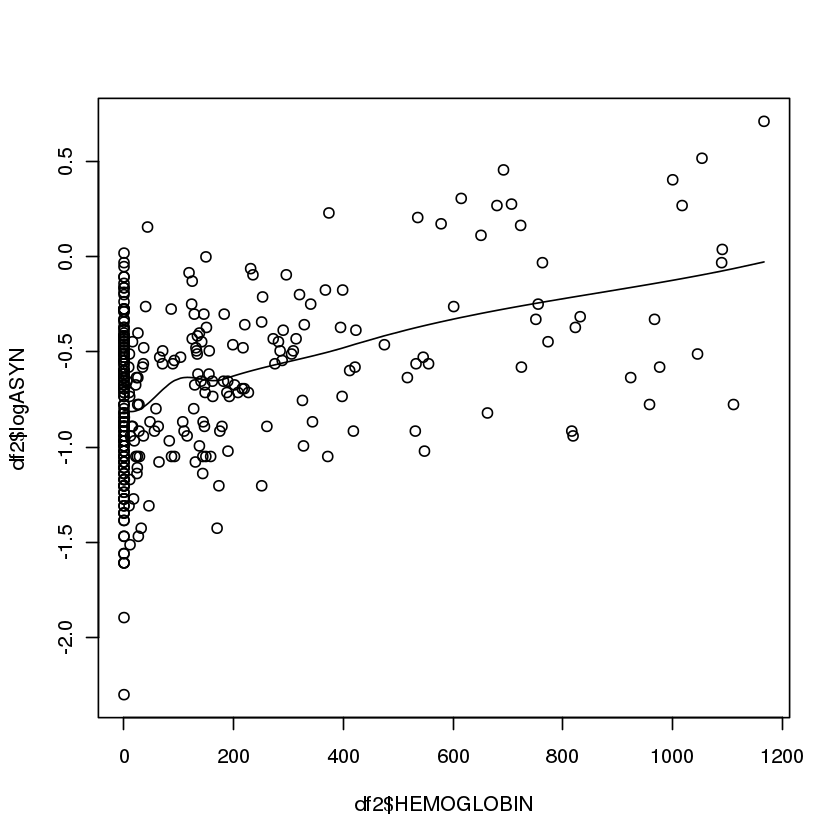

In [59]:
cat("HEMOGLOBIN<1200")
table(df1$HEMOGLOBIN<1200, useNA = "always")
cat("exclude obs with CSF-HEMOGLOBIN < 1200. But it still seeems to have a strong effect on ALPHA_SYN (below)
looking at variance, filter out obs with large HEMOGLOBIN values.
For the consistency, set the cut-off value at 1200 (PPMI max was 1227)
")
df2 = df1 %>% 
  filter(HEMOGLOBIN<1200) %>% arrange(HEMOGLOBIN)
plx = predict(loess(df2$logASYN~df2$HEMOGLOBIN), se=T)
plot(df2$HEMOGLOBIN, df2$logASYN)
lines(df2$HEMOGLOBIN, plx$fit)
## Rolling variance
# library(caTools)
# runsd(df2$logASYN, 20) %>% plot(.)
CSF = df1 %>% select(RID, DATE, rawASYN, logASYN, invnASYN, BOX, HEMOGLOBIN)

In [58]:
# DIAGNOSIS
dx_tmp = fread("../ADNI/180831/DXSUM_PDXCONV_ADNIALL.csv") 
#  summary(dx_tmp)

cat("Summary of Data
DXCURREN 1 normal, 2 MCI, 3 AD. 
DXCHANGE 1 unchange NC, 2 unchange MCI, 3 Unchange AD, 4 NC to MCI, 5 MCI to AD 6 NCI to AD, 7 MCI to NC, 8 AD to MCI 9 AD to NC
either DXCURREN or DXCHANGE were recoreded ")
dx_tmp %>% with(table(DXCURREN, DXCHANGE, useNA = "always"))
dx_tmp %>% with(table(VISCODE2, DXCURREN, useNA = "always"))
dx_tmp %>% with(table(VISCODE2, DXCHANGE, useNA = "always"))
cat("Recode diagnosis DX = 0 HC, 1 MCI, and 2 AD. Table is the following")
dx = dx_tmp %>% mutate(DX = case_when(
  DXCURREN==1 ~ 0,
  DXCURREN==2 ~ 1,
  DXCURREN==3 ~ 2,
  DXCHANGE %in% c(1,7,9) ~ 0,
  DXCHANGE %in% c(2,4,8) ~ 1,
  DXCHANGE %in% c(3,5,6) ~ 2))
dx %>% 
  with(table(VISCODE2,DX,useNA = 'always'))

cat("Individuals with DX=NA at the screening keep DX=NA in the following obs")
RIDtmp = dx %>% filter(VISCODE2=="sc" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2, DX, useNA = 'always'))
cat("Similarly, DX=NA at the baseline")
RIDtmp = dx %>% filter(VISCODE2=="bl" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2,DX,useNA = 'always'))
cat("DX=NA at the 72nd month. Indicates, DX==NA in a newer observation. NAs seem to be given for unconfirmed\n
    exclude obs with DX=NA from the analysis set")
RIDtmp = dx %>% filter(VISCODE2=="m72" & is.na(DX)) %>% distinct(RID) %>% t %>% as.vector
dx %>% filter(RID %in% RIDtmp) %>% 
  with(table(VISCODE2,DX,useNA = 'always'))
dx = dx %>% filter(!is.na(DX))


cat("Some data tables to understand data\n
DXNORM is the same as DXCURREN==1")
dx %>% with(table(DXCURREN, DXNORM, useNA = "always"))
cat("Depression is only recoreded for DXCURREN")
dx %>% with(table(DXCURREN, DXNODEP, useNA = "always"))
cat("Among MCI, some are MCI not by AD (DXMDUE==2)")
dx %>% with(table(DX, DXMDUE, useNA = "always"))
cat("The reason for MCI due to non AD etiology
1=Fronto-temporal Dementia; 2=Parkinson's Disease; 3=Huntington's Disease; 
4=Progressive Supranuclear Palsy; 5=Alcohol-related Dementia; 6=NPH; 
7=Major Depression; 8=Corticobasal Degeneration; 9=Vascular Dementia; 
10=Prion-Associated Dementia; 11=HIV; 12=Primary Progressive Aphasia; 
13=Posterior Cortical Dysfunction; 14=Other
Individuals reported with MCI with other etiology will be excluded")
dx %>% with(table(DX, DXMOTHET, useNA = "always"))
RIDtmp = dx %>% filter(DXMOTHET!=-4) %>% distinct(RID) %>% t %>% as.vector
dx = dx %>%  filter(!(RID %in% RIDtmp)) 

cat("Diagnostic certaintly of AD 1:Probable, 2:Possible")
dx %>% with(table(DX, DXAPP, useNA = "always"))
cat("Severity of AD 1:Mild, 2:Moderate, 3:Severe")
dx %>% with(table(DX, DXADES, useNA = "always")) # 


cat("The difference between diagnosis at first and last observation")
dx = dx %>% 
  mutate(DATE=as.numeric(as.Date(EXAMDATE))) %>% 
  arrange(RID, DATE)
dx1 = dx %>% group_by(RID) %>% mutate(CHANGE = last(DX) - first(DX))
dx1 %>% distinct(RID, .keep_all = T) %>% with(table(DX, CHANGE, useNA = "always"))
DX = dx %>% group_by(RID) %>% mutate(DXfirst = first(DX), DXlast = last(DX)) %>% ungroup %>% 
  select(Phase, RID, VISCODE2, DATE, DX, DXfirst, DXlast)

Summary of Data
DXCURREN 1 normal, 2 MCI, 3 AD. 
DXCHANGE 1 unchange NC, 2 unchange MCI, 3 Unchange AD, 4 NC to MCI, 5 MCI to AD 6 NCI to AD, 7 MCI to NC, 8 AD to MCI 9 AD to NC
either DXCURREN or DXCHANGE were recoreded 

        DXCHANGE
DXCURREN    1    2    3    4    5    6    7    8 <NA>
    1       0    0    0    0    0    0    0    0 1130
    2       0    0    0    0    0    0    0    0 1606
    3       0    0    0    0    0    0    0    0 1132
    <NA> 1977 2816  972   89  192    1   58    7 1120

        DXCURREN
VISCODE2    1    2    3 <NA>
            0    0    0    1
    bl    229  397  193 1188
    m06   226  354  201  835
    m108    0    0    0   98
    m12   216  291  225  753
    m120    0    0    0   71
    m132    0    0    0   52
    m144    0    0    0   21
    m18    10  226   93    0
    m24   210  180  255  651
    m36   183  139  128  368
    m48    55   19   37  560
    m60     0    0    0  400
    m72     0    0    0  370
    m84     0    0    0  213
    m96     0    0    0  134
    sc      0    0    0 1517
    uns1    1    0    0    0
    <NA>    0    0    0    0

        DXCHANGE
VISCODE2    1    2    3    4    5    6    7    8 <NA>
            0    0    0    0    0    0    0    0    1
    bl    292  468  148    1    0    0    2    0 1096
    m06   263  403  130   11   24    0    4    0  781
    m108   31   33   23    2    8    0    1    0    0
    m12   194  383  125    6   22    0   17    0  738
    m120   23   15   11    5    5    0    2    1    9
    m132    0    0    0    1    0    0    0    0   51
    m144    0    0    0    0    0    0    0    0   21
    m18     0    0    0    0    0    0    0    0  329
    m24   233  300   56   13   41    0    6    2  645
    m36    41  241   44    4   26    0   10    1  451
    m48   166  217   74   15   26    0    9    2  162
    m60   106  130   69    8   11    0    3    1   72
    m72    95   69   50    7   12    0    2    0  135
    m84    72   56   35   12    4    1    0    0   33
    m96    48   44   21    4   13    0    2    0    2
    sc    413  457  186    0    0    0    0    0  461
    uns1   

Recode diagnosis DX = 0 HC, 1 MCI, and 2 AD. Table is the following

        DX
VISCODE2   0   1   2 <NA>
           0   0   0    1
    bl   523 866 341  277
    m06  493 768 355    0
    m108  32  35  31    0
    m12  427 680 372    6
    m120  25  21  16    9
    m132   0   1   0   51
    m144   0   0   0   21
    m18   10 226  93    0
    m24  449 495 352    0
    m36  234 385 198    1
    m48  230 253 137   51
    m60  109 139  80   72
    m72   97  76  62  135
    m84   72  68  40   33
    m96   50  48  34    2
    sc   413 457 186  461
    uns1   1   0   0    0
    <NA>   0   0   0    0

Individuals with DX=NA at the screening keep DX=NA in the following obs

        DX
VISCODE2 <NA>
    bl    276
    m12     6
    sc    461
    <NA>    0

Similarly, DX=NA at the baseline

        DX
VISCODE2 <NA>
    bl    277
    m12     6
    sc    276
    <NA>    0

DX=NA at the 72nd month. Indicates, DX==NA in a newer observation. NAs seem to be given for unconfirmed

    exclude obs with DX=NA from the analysis set

        DX
VISCODE2   0   1   2 <NA>
    bl    65  70   0    0
    m06   62  65   3    0
    m12   66  63   3    0
    m24   63  58   9    0
    m36   15  52  10    0
    m48   54  51   9    1
    m60    2  22   2   10
    m72    0   0   0  135
    m84    0   0   0   11
    sc    65  53   0    0
    <NA>   0   0   0    0

Some data tables to understand data

DXNORM is the same as DXCURREN==1

        DXNORM
DXCURREN   -4    1 <NA>
    1       0 1130    0
    2    1606    0    0
    3    1132    0    0
    <NA>    0    0 6112

Depression is only recoreded for DXCURREN

        DXNODEP
DXCURREN   -4    1 <NA>
    1    1115   15    0
    2    1556   50    0
    3    1112   20    0
    <NA>    0    0 6112

Among MCI, some are MCI not by AD (DXMDUE==2)

      DXMDUE
DX       -4    1    2 <NA>
  0    1130    0    0 2035
  1       5 4290  223    0
  2    1132    0    0 1165
  <NA>    0    0    0    0

The reason for MCI due to non AD etiology
1=Fronto-temporal Dementia; 2=Parkinson's Disease; 3=Huntington's Disease; 
4=Progressive Supranuclear Palsy; 5=Alcohol-related Dementia; 6=NPH; 
7=Major Depression; 8=Corticobasal Degeneration; 9=Vascular Dementia; 
10=Prion-Associated Dementia; 11=HIV; 12=Primary Progressive Aphasia; 
13=Posterior Cortical Dysfunction; 14=Other
Individuals reported with MCI with other etiology will be excluded

      DXMOTHET
DX       -4    1   14    2 2:14    4    6 6:08    7  7:9    8    9 9:14 <NA>
  0    3165    0    0    0    0    0    0    0    0    0    0    0    0    0
  1    4295    9  108    3    2    1   16    1    9    1   50   21    2    0
  2    2297    0    0    0    0    0    0    0    0    0    0    0    0    0
  <NA>    0    0    0    0    0    0    0    0    0    0    0    0    0    0

Diagnostic certaintly of AD 1:Probable, 2:Possible

      DXAPP
DX       -4    1    2 <NA>
  0    1074    0    0 2008
  1    1397    0    0 2616
  2       3 2150   61   15
  <NA>    0    0    0    0

Severity of AD 1:Mild, 2:Moderate, 3:Severe

      DXADES
DX       -4    1    2    3 <NA>
  0    1074    0    0    0 2008
  1    1397    0    0    0 2616
  2       3  869  209   20 1128
  <NA>    0    0    0    0    0

The difference between diagnosis at first and last observation

      CHANGE
DX      -1   0   1   2 <NA>
  0      0 553  51  24    0
  1     43 559 291   0    0
  2      2 376   0   0    0
  <NA>   0   0   0   0    0

In [72]:
# Join the data
temp = inner_join(DEMO, CSF, by="RID") %>% 
  left_join(., DX, by=c("RID")) %>% # duplicated obs for DATE
  arrange(RID, DATE.y) %>% 
  group_by(RID) %>% 
  filter(DATE.x <= DATE.y) %>% 
  distinct(RID, .keep_all = T) %>% # keep the latest diagnosis after CSF sampling
  ungroup
DF = temp %>% 
  mutate(AGE=(DATE.x-DOB)/365.25,
         DATASET="ADNI",
         IID=RID) %>% 
  filter(HEMOGLOBIN<1200) %>% 
  select("DATASET", "IID","rawASYN", "logASYN", "invnASYN", "DX", "FEMALE","YEARSEDUC", "HEMOGLOBIN", "AGE", "DXfirst", "DXlast", "BOX")
cat("summary of the final data
NOTE: excluded HEMOGLOBIN>1200")
summary(DF)
cat("full model")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DX), DF) %>% summary
cat("\n\nReplacing DX with the latest DX and this has better prediction. Use the latest DX.")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DXlast), DF) %>% summary

cat("\nWhen comparing tha above model vs the above model except for the Box term, 
the former has significantly better prediction.")
anova(lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(BOX)+as.factor(DXlast), DF),
      lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+as.factor(DXlast), DF))

cat("\n\nThe boxes seem to group as 1,2,4 and 3,5. 
This is the best model (might be overfitting). PCs will be added later and decide the final model")
lm(logASYN~FEMALE+AGE+HEMOGLOBIN+YEARSEDUC+I(BOX=="Box 5" | BOX=="Box 3") + as.factor(DXlast), DF) %>% summary

summary of the final data
NOTE: excluded HEMOGLOBIN>1200

   DATASET               IID            rawASYN          logASYN       
 Length:301         Min.   :   3.0   Min.   :0.1000   Min.   :-2.3026  
 Class :character   1st Qu.: 319.0   1st Qu.:0.3800   1st Qu.:-0.9676  
 Mode  :character   Median : 626.0   Median :0.5200   Median :-0.6539  
                    Mean   : 655.9   Mean   :0.5478   Mean   :-0.6891  
                    3rd Qu.:1013.0   3rd Qu.:0.6500   3rd Qu.:-0.4308  
                    Max.   :1423.0   Max.   :1.6800   Max.   : 0.5188  
    invnASYN             DX             FEMALE        YEARSEDUC    
 Min.   :-3.0149   Min.   :0.0000   Min.   :0.000   Min.   : 6.00  
 1st Qu.:-0.7816   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:14.00  
 Median :-0.1488   Median :1.0000   Median :0.000   Median :16.00  
 Mean   :-0.2293   Mean   :0.9834   Mean   :0.402   Mean   :15.57  
 3rd Qu.: 0.4213   3rd Qu.:2.0000   3rd Qu.:1.000   3rd Qu.:18.00  
 Max.   : 1.4337   Max.   :2.0000   Max.   :1.000   Max.   :20.00  
   HEMOGLOBIN       

full model


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    as.factor(BOX) + as.factor(DX), data = DF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2775 -0.2310  0.0185  0.2551  0.8870 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.2229967  0.2702916  -4.525 8.83e-06 ***
FEMALE               0.0172377  0.0440422   0.391   0.6958    
AGE                  0.0051252  0.0029755   1.722   0.0861 .  
HEMOGLOBIN           0.0006673  0.0000822   8.118 1.37e-14 ***
YEARSEDUC           -0.0112526  0.0071294  -1.578   0.1156    
as.factor(BOX)Box 2 -0.0257328  0.0682648  -0.377   0.7065    
as.factor(BOX)Box 3  0.1258570  0.0664429   1.894   0.0592 .  
as.factor(BOX)Box 4 -0.0186601  0.0667511  -0.280   0.7800    
as.factor(BOX)Box 5  0.1321308  0.0660056   2.002   0.0462 *  
as.factor(DX)1       0.2227098  0.0501474   4.441 1.27e-05 ***
as.factor(DX)2       0.2770634  0.0554239   4.999 9.99e-07 ***
---
Signif. codes



Replacing DX with the latest DX and this has better prediction. Use the latest DX.


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    as.factor(BOX) + as.factor(DXlast), data = DF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2426 -0.2234  0.0241  0.2454  0.8850 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -1.229e+00  2.681e-01  -4.586 6.72e-06 ***
FEMALE               1.638e-02  4.343e-02   0.377   0.7063    
AGE                  4.706e-03  2.954e-03   1.593   0.1122    
HEMOGLOBIN           6.574e-04  8.165e-05   8.052 2.13e-14 ***
YEARSEDUC           -1.159e-02  7.072e-03  -1.638   0.1025    
as.factor(BOX)Box 2 -2.358e-02  6.782e-02  -0.348   0.7283    
as.factor(BOX)Box 3  1.261e-01  6.601e-02   1.910   0.0571 .  
as.factor(BOX)Box 4 -3.357e-02  6.649e-02  -0.505   0.6140    
as.factor(BOX)Box 5  1.124e-01  6.565e-02   1.712   0.0880 .  
as.factor(DXlast)1   2.686e-01  6.171e-02   4.352 1.87e-05 ***
as.factor(DXlast)2   2.961e-01  5.225e-02   5.668 3.49e-08 ***
---
Signif. c


When comparing tha above model vs the above model except for the Box term, 
the former has significantly better prediction.

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
290,36.62973,NA,NA,NA,NA
294,38.03846,-4,-1.408731,2.788254,0.02677328




The boxes seem to group as 1,2,4 and 3,5. 
This is the best model (might be overfitting). PCs will be added later and decide the final model


Call:
lm(formula = logASYN ~ FEMALE + AGE + HEMOGLOBIN + YEARSEDUC + 
    I(BOX == "Box 5" | BOX == "Box 3") + as.factor(DXlast), data = DF)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24709 -0.22863  0.01974  0.25629  0.88271 

Coefficients:
                                         Estimate Std. Error t value Pr(>|t|)
(Intercept)                            -1.259e+00  2.588e-01  -4.864 1.88e-06
FEMALE                                  1.533e-02  4.302e-02   0.356  0.72180
AGE                                     4.802e-03  2.917e-03   1.646  0.10076
HEMOGLOBIN                              6.611e-04  8.099e-05   8.163 9.80e-15
YEARSEDUC                              -1.136e-02  7.014e-03  -1.620  0.10636
I(BOX == "Box 5" | BOX == "Box 3")TRUE  1.386e-01  4.189e-02   3.308  0.00106
as.factor(DXlast)1                      2.680e-01  6.139e-02   4.365 1.77e-05
as.factor(DXlast)2                      2.943e-01  5.177e-02   5.684 3.17e-08
                                     